In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy.random as random

In [512]:
def square_lattice(i,j, Lx = None, Ly = None): 
    ''' Square lattice with close boundary conditions
    '''
    neighbours = []
    if i+1<Lx:
        neighbours.append([i+1,j])
    if i-1> -1:
        neighbours.append([i-1,j])
    if j+1<Ly:
        neighbours.append([i,j+1])
    if j-1> -1:
        neighbours.append([i,j-1])
        
    return neighbours
    
class game:
    def __init__(self, H, Memb = None, Ls = None, Ly = None, lattice = square_lattice):
        self.H = H
            
        if Memb is None:
            self.Hemb = H*0.0
            self.Memb = H.shape[0]
            self.usedS = np.zeros(self.Memb)
        else:
            self.Hemb = np.zeros((Memb, Memb))
            self.Memb = Memb
            self.usedS = np.zeros(Memb)
        
        if Ls is None:
            L = np.int(np.sqrt(self.Memb))
            self.Lx, self.Ly = L, L
        else:
            self.Lx, self,Ly = Ls[0], Ls[1]
        
        self.N = 0
        self.N0 = 0
        self.lattice = lattice
        self.copyadd = 1
        
        
    def get_state(self):
        return self.Hnew, self.copyadd
    
    def get_poss_actions(self)
        actions = []
        if self.copyadd:
            pass
        else:
            pass
        
    
    def __len__(self):
        return self.N
    
    def copy_spin(self, i, j):
        if i<0 or i>N:
            return 0
        if j<0 or j>N:
            return 0
        
        self.N += 1
        self.Hemb[i,j] = 1.0
        self.Hemb[j,i] = 1.0
        
    def add_new_spin(self, i, interactions = 2*random.rand(4)-1):
        neighbours = self.get_neighbours(i)
        self.usedS[i] = 1
        self.N += 1
        self.N0 += 1
        for site, jint in zip(neighbours, interactions):
            j = site[1]*self.Lx+site[0]
            # if self.usedS[j]==1:
            #     self.Hemb[i,j] = jint
            #     self.Hemb[j,i] = jint
            # print(j)
            self.Hemb[i,j] = jint*self.usedS[j]
            self.Hemb[j,i] = jint*self.usedS[j]


    def get_neighbours(self, i):
        ix, iy = i%self.Lx, i//self.Lx
        return self.lattice(ix, iy, self.Lx, self.Ly)
    
    def print(self):
        for i in range(self.Hemb.shape[0]):
            stre = self.Memb*'{:.2f} '
            print(stre.format(*self.Hemb[i,:]))
            
    def plot(self, ax = None, **kwargs):
        if ax is None:
            fig, ax = plt.subplots(1,1, **kwargs)
        
        idc0 = np.arange(self.Memb)
        idcs = idc0[self.usedS==1]
        ix, iy = idcs%self.Lx, idcs//self.Lx
        
        ax.scatter(ix,iy)
        
        #print(idcs)
        xx = []
        yy = []
        uu = []
        vv = []
        cc = []
        if len(idcs)>2:
            for i0, i in enumerate(idcs):
                ix0, iy0 = i%self.Lx, i//self.Lx
                idc1 = idc0[np.abs(self.Hemb[i,:])>0]
                if len(idc1)>0:
                    ix1, iy1 = idc1%self.Lx, idc1//self.Lx
                    
                    xx.extend(ix0+ix1*0)
                    yy.extend(iy0+iy1*0) 
                    uu.extend(ix1-ix0) 
                    vv.extend(iy1-iy0)
                    cc.extend(1+self.Hemb[i,idc1]/2.0)
                    
        ax.quiver(xx,yy,uu,vv,cc,
            scale = self.Lx, headwidth = 0, cmap='seismic' )
            
        #ax.quiver
        ax.set_aspect('equal')
        #ax.set_clim(-1,1)

        ax.set_xlim(-0.05,self.Lx+0.05)
        ax.set_ylim(-0.05,self.Ly+0.05)
        return fig, ax

In [513]:
Hint = random.randn(9,9)

In [523]:
Hint = Hint +Hint.transpose()

In [524]:
newg = game(Hint, Memb = 25)

In [525]:
newg.Memb

25

In [526]:
[].extend([1,3,4])

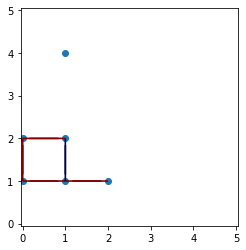

In [529]:
newg.add_new_spin(10)
newg.add_new_spin(5)
newg.add_new_spin(6)
newg.add_new_spin(11)
newg.add_new_spin(21)
newg.add_new_spin(7)

fig, ax = newg.plot()
#ax.quiver([[0,1,2], [1,1,1]],[1,1,1],[0,0,0,0,0,0])